In [ ]:
!pip3 install torch torchvision torchaudio


Epoch 1, Loss: 13.566365578191743
Epoch 2, Loss: 13.286324837224946
Epoch 3, Loss: 13.11502135571816
Epoch 4, Loss: 12.852331202664821
Epoch 5, Loss: 12.596305902055699
Epoch 6, Loss: 12.350618485924151
Epoch 7, Loss: 12.100617717495926
Epoch 8, Loss: 11.835692371395853
Epoch 9, Loss: 11.570615096057919
Epoch 10, Loss: 11.30787930385672
Epoch 11, Loss: 11.21948851441308
Epoch 12, Loss: 10.954963560584638
Epoch 13, Loss: 10.815084361343933
Epoch 14, Loss: 10.591825540117222
Epoch 15, Loss: 10.362953172313224
Epoch 16, Loss: 10.278734275762984
Epoch 17, Loss: 10.128211769268667
Epoch 18, Loss: 10.002186823234284
Epoch 19, Loss: 9.810552693099426
Epoch 20, Loss: 9.734196724651529
Epoch 21, Loss: 9.581404143957784
Epoch 22, Loss: 9.634305583487311
Epoch 23, Loss: 9.524101408265478
Epoch 24, Loss: 9.395042337101998
Epoch 25, Loss: 9.352695382756295
Epoch 26, Loss: 9.337284774231396
Epoch 27, Loss: 9.32382756514515
Epoch 28, Loss: 9.338367558211731
Epoch 29, Loss: 9.29156667036976
Epoch 30, 

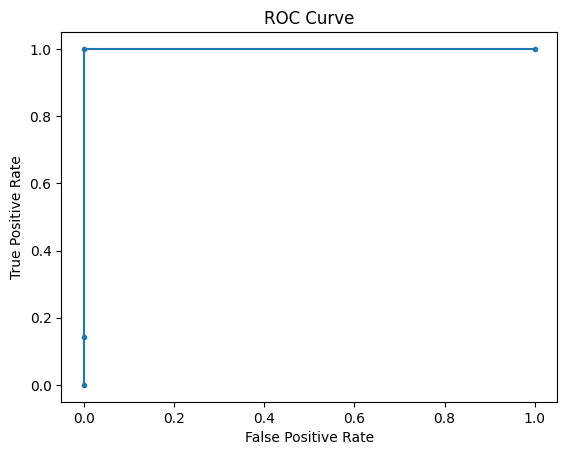

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('../../data/BCP.csv')

# Bỏ qua cột đầu tiên là ngày giờ
features = data.iloc[:, 1:]  # Bỏ cột ngày giờ nếu cần

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Chuyển đổi dữ liệu thành tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Định nghĩa DataLoader
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=32, shuffle=True)

# Định nghĩa mô hình VAE với PyTorch
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Khởi tạo mô hình, tiêu chuẩn và bộ tối ưu hóa
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
epochs = 150
model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}')

# Dự đoán và đánh giá
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = torch.mean((X_test - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng để phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Đánh giá với ROC AUC
roc_auc = roc_auc_score(pred_labels, reconstruction_loss)
print(f'ROC AUC Score: {roc_auc}')

# Vẽ biểu đồ ROC
fpr, tpr, _ = roc_curve(pred_labels, reconstruction_loss)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


Epoch 1, Loss: 14.99070872431216
Epoch 2, Loss: 15.005442412003227
Epoch 3, Loss: 14.995363318401834
Epoch 4, Loss: 14.93957055133322
Epoch 5, Loss: 14.904204990552818
Epoch 6, Loss: 14.834192027216373
Epoch 7, Loss: 14.805119721785836
Epoch 8, Loss: 14.751072759213654
Epoch 9, Loss: 14.680385423743207
Epoch 10, Loss: 14.723670296047045
Epoch 11, Loss: 14.716308925462807
Epoch 12, Loss: 14.700726384701936
Epoch 13, Loss: 14.593211298403533
Epoch 14, Loss: 14.619833904763926
Epoch 15, Loss: 14.621309363323709
Epoch 16, Loss: 14.555826601774797
Epoch 17, Loss: 14.618463599163553
Epoch 18, Loss: 14.487505042034647
Epoch 19, Loss: 14.2975201814071
Epoch 20, Loss: 14.421090499214504
Epoch 21, Loss: 14.28759533426036
Epoch 22, Loss: 14.23446920643682
Epoch 23, Loss: 14.342525979746943
Epoch 24, Loss: 14.21576392132303
Epoch 25, Loss: 14.20815608812415
Epoch 26, Loss: 14.255878946055537
Epoch 27, Loss: 14.075783107591713
Epoch 28, Loss: 14.075660705566406
Epoch 29, Loss: 14.168386044709578
Ep

/var/folders/rl/f1v_h4_943qbnnbhlgghf17m0000gn/T/ipykernel_26831/1953380796.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['timestamp'] = pd.to_datetime(data['Time'])  # Chuyển đổi cột thời gian


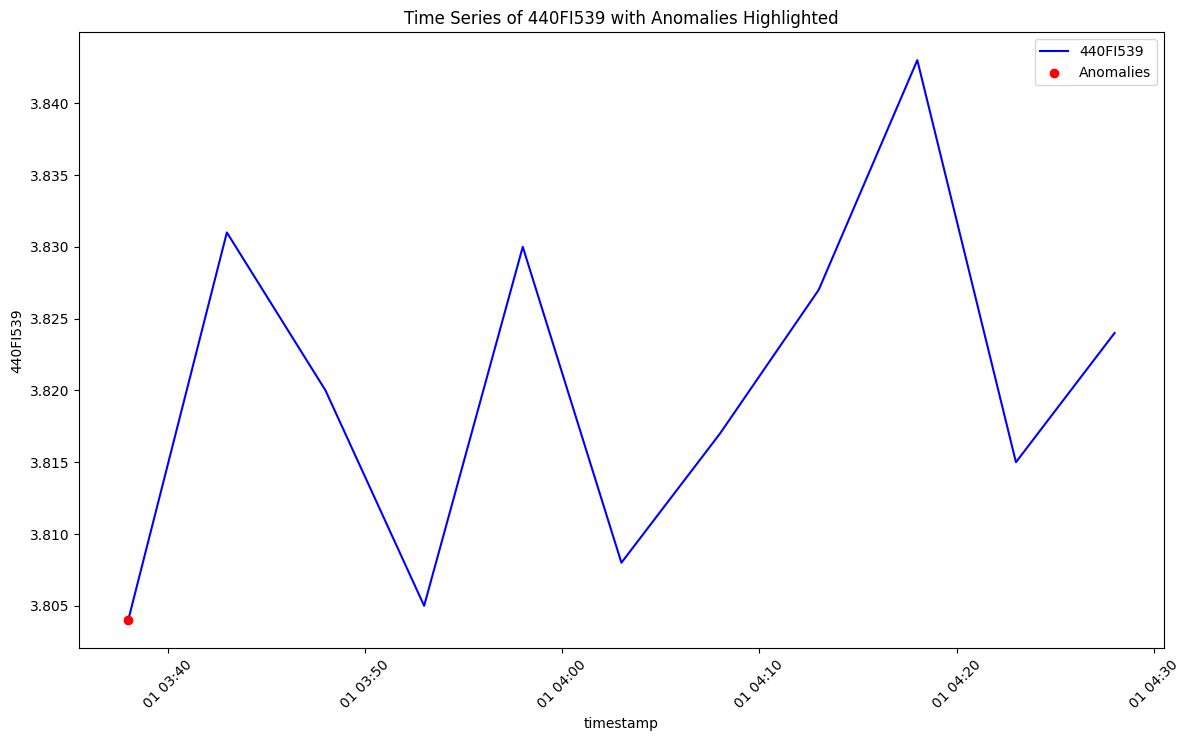

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Định nghĩa mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2_mean = nn.Linear(16, latent_dim)
        self.fc2_logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 16)
        self.fc4 = nn.Linear(16, input_dim)

    def encoder(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

# Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/BCP.csv')


# Chọn cột để hiển thị, giả sử cột đó là '440FI540'
column_name = '440FI539'
data['timestamp'] = pd.to_datetime(data['Time'])  # Chuyển đổi cột thời gian
data.set_index('timestamp', inplace=True)

# Chuẩn hóa giá trị
scaler = StandardScaler()
data['scaled_value'] = scaler.fit_transform(data[[column_name]])

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(data['scaled_value'].values, test_size=0.2)

# Đảm bảo rằng dữ liệu đầu vào có kích thước phù hợp với mô hình
input_dim = 12  # Số chiều mà mô hình mong đợi
adjusted_size_train = (len(X_train) // input_dim) * input_dim
adjusted_size_test = (len(X_test) // input_dim) * input_dim
X_train = X_train[:adjusted_size_train]
X_test = X_test[:adjusted_size_test]

# Reshape để phù hợp với mô hình
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_dim)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, input_dim)

# Khởi tạo mô hình VAE, tiêu chuẩn và bộ tối ưu hóa
latent_dim = 2
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
epochs = 50
model.train()
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=32)
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}')

# Đánh giá mô hình và phát hiện bất thường
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = torch.mean((X_test - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng để phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Tạo DataFrame để chứa dữ liệu và kết quả phát hiện bất thường
result_df = pd.DataFrame({
    'timestamp': data.index[-len(X_test):],  # Lấy thời gian tương ứng từ tập kiểm tra
    'value': data[column_name].values[-len(X_test):],
    'reconstruction_loss': reconstruction_loss,
    'anomaly': pred_labels
})

# Vẽ biểu đồ với các điểm bất thường
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ đường cho cột đã chọn
plt.plot(result_df['timestamp'], result_df['value'], label=column_name, color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel(column_name)
plt.title(f'Time Series of {column_name} with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()


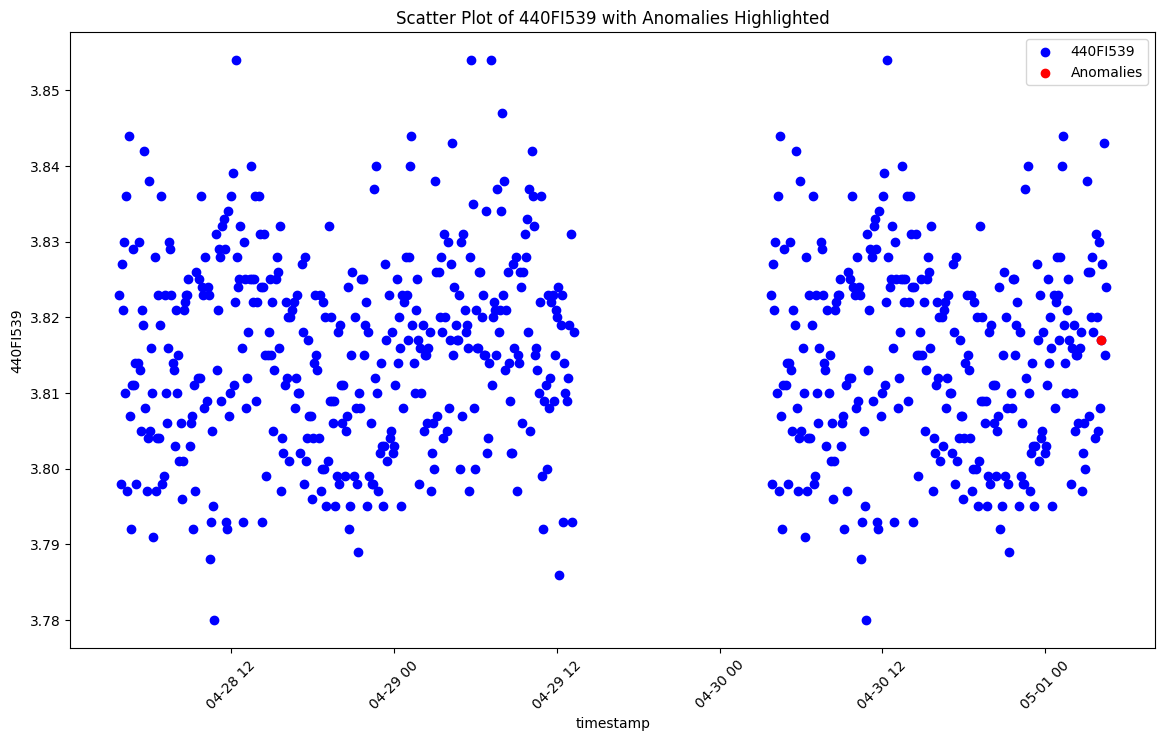

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Vẽ toàn bộ dữ liệu gốc
plt.scatter(data.index, data['440FI539'], label='440FI539', color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]  # Chắc chắn rằng `result_df` chứa thông tin chính xác
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel('440FI539')
plt.title('Scatter Plot of 440FI539 with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()
